In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [50]:
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

In [171]:
def raised_cosine(n_bases, bin_size, end_peak_times, offset, stretching='log'):
    '''Raised cosine basis
      ^
     / \
    /   \______
         ^
        / \
    ___/   \___
            ^
           / \
    ______/   \
    Make log or linearly stretched basis consisting of raised cosines.
    Log stretching allows faster changes near the event.
    
    Parameters
    ----------
    n_bases : int
        Number of basis vectors
    bin_size : float
        time bin size (separation for representing basis
    end_peak_times : array
        [2 x 1] array containg [1st_peak,  last_peak], the peak
             (i.e. center) of the first and the last raised cosine basis vectors
    offset: float
        offset for log stretching of x axis:  y = log(t + offset)
        (larger offset -> more nearly linear stretching)
    stretching : str
        "log" or "linear"

    Returns
    -------
    time : array
        time lattice on which basis is defined
    bases : array
        basis itself
    centers : array
        centers of each basis function

    Example
    -------
    time, bases, centers = log_raised_cosine(10, 1, [0, 500], 2);
    '''
    if stretching == 'log':
        if offset <= 0:
            raise ValueError('offset must be greater than 0')
        #log stretching x axis (and its inverse)
        stretch = lambda x: np.log(x + 1e-20)
        inv_stretch = lambda x: np.exp(x) - 1e-20
    elif stretching == 'linear':
        stretch = lambda x: x
        inv_stretch = lambda x: x
        offset = 0
    else:
        raise ValueError('stretching must be "log" or "linear"')
    
    x_range = stretch(end_peak_times + offset)

    db = np.diff(x_range) / (n_bases - 1)  # spacing between raised cosine peaks

    centers = np.arange(x_range[0], x_range[1] + db / 2, db)  # centers for basis vectors

    max_time_bin = inv_stretch(x_range[1] + db) - offset  # maximum time bin (originally 2 * db)

    time = np.arange(0, max_time_bin, bin_size)
    
    centers_tiled = np.tile(centers, (time.size, 1))

    time_stretch_tiled = np.tile(stretch(time + offset)[:, np.newaxis], (1, n_bases))

    def _raised_cosine(time, centers, dc):
        center_adjusted = (time - centers) * np.pi / dc # originally divided by 2
        center_adjusted_min = np.minimum(np.pi, center_adjusted)
        center_adjusted_min_max = np.maximum(-np.pi, center_adjusted_min)
        return (np.cos(center_adjusted_min_max) + 1) / 2

    bases = _raised_cosine(time_stretch_tiled, centers_tiled, db)

    centers = inv_stretch(centers)

    return time, bases, centers

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


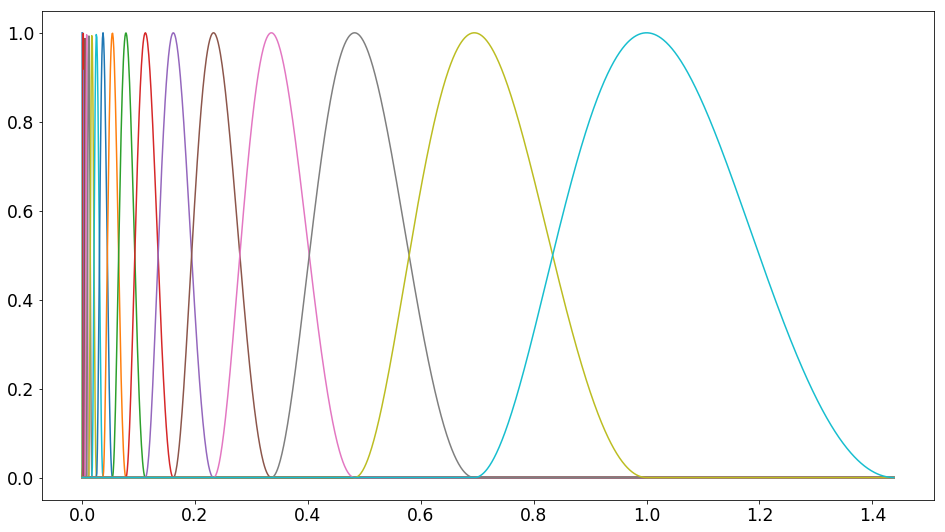

In [243]:
bin_size = .001
n_bases = 20

time, bases, centers = raised_cosine(n_bases, bin_size, np.array([0, 1]), .001)
plt.plot(time, bases)
# plt.plot([1000, 1000], [0, 1])
print(bases.sum(1)[:10])
# plt.xlim(0,10)

In [258]:
# spike_times = np.array([.01, 0.05, .1 , 1])
spike_times = np.random.uniform(0,1,10)
bin_spikes = np.zeros((len(spike_times), n_bases))

def index(t, bin_size):
    return np.ceil(t / bin_size).astype(int)

idxs = index(spike_times, bin_size)

for i, j in enumerate(idxs):
    bin_spikes[i, :] = bases[j, :]

In [254]:
bases.shape

(1439, 20)

In [261]:
bin_spikes[0,:].sum()

0.9999999999999991

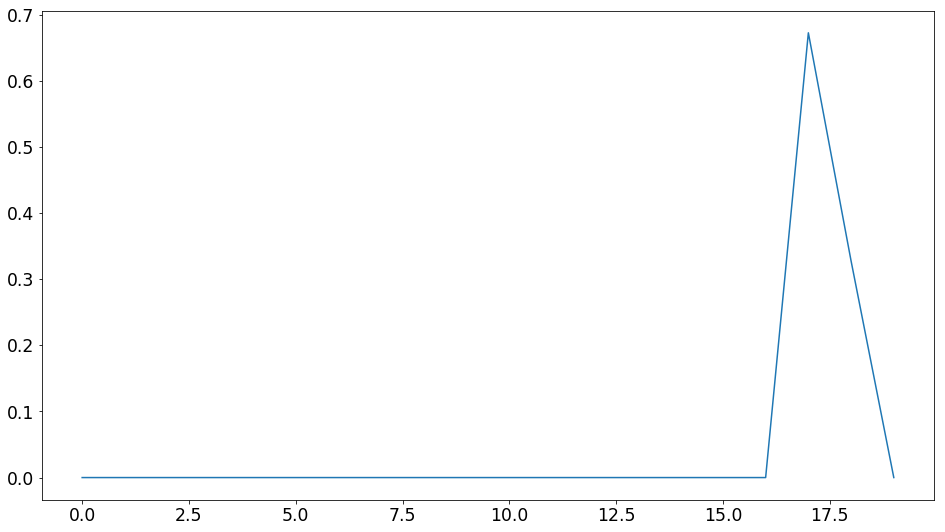

In [260]:
plt.plot(bin_spikes[0,:])

In [246]:
# spike_bases = np.array([np.convolve(spike_times, basis, 'same') for basis in bases.T]).T
spike_bases = np.array([np.convolve(basis, spike_times, 'same') for basis in bases.T]).T

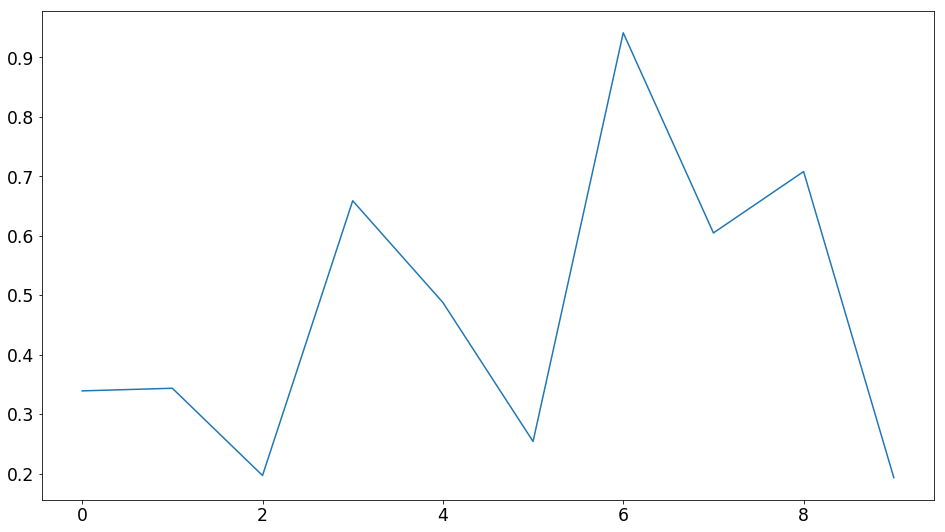

In [255]:
plt.plot(spike_bases[:10,0])

In [225]:
spike_times

array([1.64855634e-01, 5.21870881e-01, 5.46242700e-01, 3.83024066e-01,
       1.76026299e-01, 5.05691821e-01, 5.51060780e-02, 8.79505533e-01,
       4.91504602e-02, 8.94279313e-01, 6.27134304e-01, 3.57091420e-02,
       5.35901833e-01, 9.10884713e-01, 8.48180204e-01, 3.58658649e-01,
       6.57770902e-01, 2.12664333e-01, 7.07108106e-01, 5.55175657e-01,
       7.01469185e-01, 6.37179505e-01, 4.79256946e-01, 6.66405229e-01,
       8.11730415e-01, 3.86736727e-01, 3.45724464e-01, 2.42467089e-01,
       7.52620503e-01, 1.12676554e-01, 6.58586222e-01, 5.28805192e-01,
       5.03512011e-02, 9.70112185e-02, 6.70060635e-01, 6.78036613e-01,
       7.02211893e-01, 7.74507616e-01, 3.97769330e-01, 7.22071265e-01,
       1.44184119e-01, 9.30569132e-01, 8.79059043e-01, 9.56880898e-01,
       7.29738373e-01, 4.19959226e-01, 1.36794449e-01, 8.85252225e-01,
       5.36477158e-01, 2.34921896e-01, 6.08720901e-01, 3.47155870e-01,
       3.40460936e-01, 4.02020543e-01, 4.95644699e-01, 7.34921398e-01,
      

In [174]:
def test_log_raised_cosine():
    time, bases, centers = raised_cosine(11, .01, np.array([0, 1003]), 1)
    # all sum to one until the last peak
    assert all(bases[:1003].sum(1) - 1 < 1e-15)
    
def test_linear_raised_cosine():
    time, bases, centers = raised_cosine(11, .01, np.array([0, 1003]), 1, stretching='linear')
    # all sum to one until the last peak
    assert all(bases[:1003].sum(1) - 1 < 1e-15)
    
test_log_raised_cosine()
test_linear_raised_cosine()

In [59]:
orth(bases).sum(axis=1)

array([-7.35425469e-01,  1.86107246e-02,  3.44942419e-01, ...,
       -8.05922956e-08, -3.19781913e-08, -5.44458815e-09])

# linear

In [141]:
def raised_cosine(n_bases, n_bins):
    '''

    For raised cosine, the spacing between the centers must be 1/4 of the
    width of the cosine
    
    Parameters
    ----------
    n_bases : int
        number of bases
    n_bins : int
        number of bins for the basis functions
    '''
    time = np.arange(n_bins)
    time_idxs = np.tile(time[:, np.newaxis], (1, n_bases)) # time indices for basis

    db = n_bins / (3 + n_bases) # spacing between bumps
    width = 2 * db # width of each bump (was previously 4 which gave a sum of 2)
    centers = 2 * db + db * np.arange(n_bases)
    # location of each bump centers
    
    def _raised_cosine(x, period):
        mask = abs(x / period) < 0.5
        return mask * (np.cos(x * 2 * np.pi / period) * 0.5 + 0.5)
    
    bases = _raised_cosine(time_idxs - np.tile(centers, (n_bins, 1)), width)
    
    return time, bases, centers

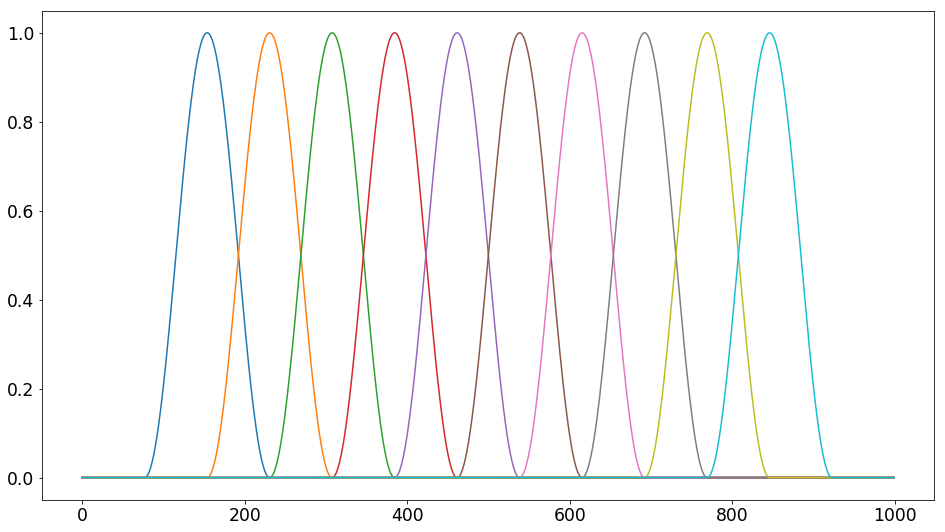

In [142]:
binfun = lambda t, bin_size: (t == 0) + np.ceil(t / bin_size)


time, bases, centers = raised_cosine(10, 1000)
# print(bases.sum(axis=1))
plt.plot(bases);

In [81]:
np.diff(centers)

array([7.69230769, 7.69230769, 7.69230769, 7.69230769, 7.69230769,
       7.69230769, 7.69230769, 7.69230769, 7.69230769])

In [ ]:
def rcosfilter2(N, alpha, Ts, Fs):
    """
    Generates a raised cosine (RC) filter (FIR) impulse response.
    Parameters
    ----------
    N : int
        Length of the filter in samples.
    alpha : float
        Roll off factor (Valid values are [0, 1]).
    Ts : float
        Symbol period in seconds.
    Fs : float
        Sampling Rate in Hz.
    Returns
    -------
    time_idx : 1-D ndarray (float)
        Array containing the time indices, in seconds, for the impulse response.
    h_rc : 1-D ndarray (float)
        Impulse response of the raised cosine filter.
    """

    T_delta = 1/float(Fs)
    time_idx = ((np.arange(N)-N/2))*T_delta
    sample_num = np.arange(N)
    h_rc = np.zeros(N, dtype=float)

    for x in sample_num:
        t = (x-N/2)*T_delta
        if t == 0.0:
            h_rc[x] = 1.0
        elif alpha != 0 and t == Ts/(2*alpha):
            h_rc[x] = (np.pi/4)*(np.sin(np.pi*t/Ts)/(np.pi*t/Ts))
        elif alpha != 0 and t == -Ts/(2*alpha):
            h_rc[x] = (np.pi/4)*(np.sin(np.pi*t/Ts)/(np.pi*t/Ts))
        else:
            h_rc[x] = (np.sin(np.pi*t/Ts)/(np.pi*t/Ts))* \
                    (np.cos(np.pi*alpha*t/Ts)/(1-(((2*alpha*t)/Ts)*((2*alpha*t)/Ts))))

    return time_idx, h_rc

In [ ]:
def rcosfilter(N, beta, Ts, Fs):
    t = (np.arange(N) - N / 2) / Fs
    first = np.abs(2 * t) == Ts / beta
    second = np.pi / 4 * np.sinc(t / Ts)
    third = np.sinc(t / Ts) * np.cos(np.pi * beta * t / Ts) / (1 - (2 * beta * t / Ts)**2)
    return np.where(first, second, third)

In [ ]:
plt.plot(rcosfilter2(100, 1, 100, .1)[1])

In [ ]:
plt.plot(rcosfilter(100, 1, 100, .1))

In [ ]:
np.allclose(rcosfilter2(100, 1, 100, .1)[1], rcosfilter(100, 1, 100, .1))

In [ ]:
%timeit rcosfilter(100, 1, 100, .1)

In [ ]:
%timeit rcosfilter2(100, 1, 100, .1)[1]